In [2]:
# setup code, auto reload your .py file
%load_ext autoreload
%autoreload 2

In [26]:
# numpy
import numpy as np
np.random.seed(233)

# matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
from qzynn import *

In [10]:
from qzynn.modules.base import Module
from qzynn.modules.activation import ReLU, Tanh
from qzynn.modules.linear import Linear

class FNN:
    def __init__(self, in_features, hidden_sizes):
        self.linear1 = Linear(in_features, hidden_sizes[0])
        self.tanh = Tanh() 
        self.hidden_layers = []
        for i in range(len(hidden_sizes) - 1):
            layer = Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden_layers.append(layer)
        self.linear_final = Linear(hidden_sizes[-1], 1) 
        self.layers = [self.linear1] + self.hidden_layers + [self.linear_final]
    
    def forward(self, input):
        output = self.linear1.forward(input)
        output = self.tanh.forward(output)  # 将激活函数换成tanh
        for layer in self.hidden_layers:
            output = layer.forward(output)
            output = self.tanh.forward(output)  # 将激活函数换成tanh
        output = self.linear_final.forward(output)
        return output
    
    def backward(self, output_grad):
        output_grad = self.linear_final.backward(output_grad)
        for layer in reversed(self.hidden_layers):
            output_grad = self.tanh.backward(output_grad)  # 对应的反向传播也要使用tanh的反向
            output_grad = layer.backward(output_grad)
        output_grad = self.tanh.backward(output_grad)  # 对应的反向传播也要使用tanh的反向
        output_grad = self.linear1.backward(output_grad)
        return output_grad


Epoch 0, Loss: 0.0036462035953337187, LR: 0.0045000000000000005
Epoch 50, Loss: 0.004179537815402926, LR: 0.0045000000000000005
Epoch 100, Loss: 0.001117635274207574, LR: 0.004050000000000001
Epoch 150, Loss: 0.0008191725605302446, LR: 0.004050000000000001
Epoch 200, Loss: 0.00014414957035000487, LR: 0.0036450000000000007
Epoch 250, Loss: 9.101702178159733e-05, LR: 0.0036450000000000007
Epoch 300, Loss: 9.980797407775361e-05, LR: 0.003280500000000001
Epoch 350, Loss: 9.29416341227694e-05, LR: 0.003280500000000001
Epoch 400, Loss: 7.392332052003693e-05, LR: 0.002952450000000001
Epoch 450, Loss: 7.030448159844485e-05, LR: 0.002952450000000001
Epoch 500, Loss: 7.597376007148851e-05, LR: 0.002657205000000001
Epoch 550, Loss: 0.00011281292266742664, LR: 0.002657205000000001
Epoch 600, Loss: 0.00012253181599343027, LR: 0.002391484500000001
Epoch 650, Loss: 0.00014323165921258896, LR: 0.002391484500000001
Epoch 700, Loss: 0.00012242636760289514, LR: 0.002152336050000001
Epoch 750, Loss: 0.000

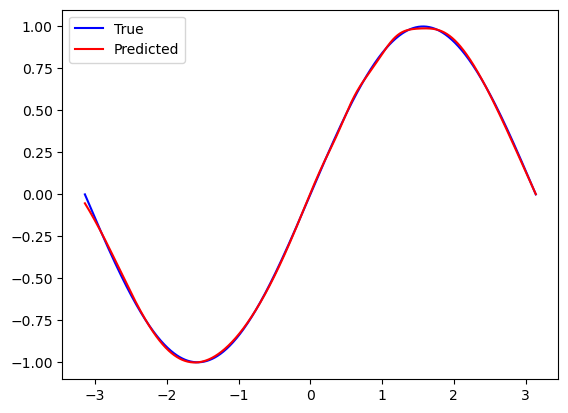

In [9]:
from qzynn.modules.loss import MSELoss
from qzynn.optim.sgd import SGD

# 生成数据
def generate_data(num_samples):
    X = np.linspace(-np.pi, np.pi, num_samples)
    Y = np.sin(X) 
    return X, Y

def train(model, X, Y, epochs, optimizer, loss_fn, lr_decay=None):
    for epoch in range(epochs):
        total_loss = 0
        for x, y_true in zip(X, Y):
            y_pred = model.forward(np.array([x]))
            loss = loss_fn.forward(y_pred, np.array([y_true]))
            total_loss += loss
            loss_fn.backward()
            optimizer.step()

        if lr_decay and epoch % lr_decay['interval'] == 0:
            new_lr = optimizer.lr * lr_decay['factor']
            optimizer.update_learning_rate(new_lr)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / len(X)}, LR: {optimizer.lr}")


def test(model, X, Y):
    Y_pred = []
    total_loss = 0
    for x, y_true in zip(X, Y):
        y_pred = model.forward(np.array([x]))
        Y_pred.append(y_pred[0])  # 假设输出是单一值的数组
        total_loss += abs(y_pred[0] - y_true)  # 计算平方误差

    mean_error = total_loss / len(X)  # 计算平均误差
    return Y_pred, mean_error


# 主程序
num_samples = 1000
epochs = 2001
learning_rate = 0.005

X, Y = generate_data(num_samples)
model = FNN(1, [20, 20])
optimizer = SGD(model, lr=learning_rate)
loss_fn = MSELoss(model)

lr_decay = {
    'factor': 0.9,  # 每次衰减到原来的90%
    'interval': 100  # 每100个epoch衰减一次
}

train(model, X, Y, epochs, optimizer, loss_fn, lr_decay)
Y_pred, test_me = test(model, X, Y)

print(f"Test Mean Error: {test_me}")

plt.plot(X, Y, color='blue', label='True')
plt.plot(X, Y_pred, color='red', label='Predicted')
plt.legend()
plt.show()

In [6]:
from qzynn.modules.loss import CrossEntropyLoss

class FNN_Classifier:
    def __init__(self, input_dim, hidden_sizes, output_dim):
        self.layers = []
        # 输入层到第一个隐藏层
        self.layers.append(Linear(input_dim, hidden_sizes[0]))
        self.layers.append(ReLU())
        
        # 隐藏层
        for i in range(1, len(hidden_sizes)):
            self.layers.append(Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(ReLU())
        
        # 最后一层到输出层
        self.layers.append(Linear(hidden_sizes[-1], output_dim))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

In [21]:
from sklearn.model_selection import train_test_split
import os
from PIL import Image

# 数据加载和预处理
def load_data(data_dir):
    images = []
    labels = []
    for label in range(1, 13):  # 12个类别
        folder_path = os.path.join(data_dir, str(label))
        for img_filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_filename)
            img = Image.open(img_path).convert('L')
            img_array = np.asarray(img).reshape(-1) / 255.0  # 归一化
            images.append(img_array)
            labels.append(label - 1)  # 标签从0开始
    return np.array(images), np.array(labels)

data_dir = '../test_data'
X, Y = load_data(data_dir)

In [8]:
def save_model(model, epoch):
    params = {}
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Linear):  # Check if it is a Linear layer
            params[f'W_{i}'] = layer.params['W']
            params[f'b_{i}'] = layer.params['b']
    np.savez(f'model_epoch_{epoch}.npz', **params)

def load_model(model, filename):
    data = np.load(filename)
    idx = 0
    for layer in model.layers:
        if isinstance(layer, Linear):
            layer.params['W'] = data[f'W_{idx}']
            layer.params['b'] = data[f'b_{idx}']
            idx += 2

In [11]:
from qzynn.optim.sgd import SGD

model = FNN_Classifier(input_dim=784, hidden_sizes=[256,128, 64], output_dim=12)
optimizer = SGD(model, lr=0.005)
loss_fn = CrossEntropyLoss(model, label_num=12)

def train(model, X, Y, X_val, Y_val, epochs, optimizer, loss_fn, lr_decay=None):
    for epoch in range(epochs):
        total_loss = 0
        for x, y_true in zip(X, Y):
            y_pred = model.forward(x)
            loss = loss_fn.forward(y_pred, y_true)
            total_loss += loss
            loss_fn.backward()
            optimizer.step()

        if lr_decay and epoch % lr_decay['interval'] == 0:
            new_lr = optimizer.lr * lr_decay['factor']
            optimizer.update_learning_rate(new_lr)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / len(X)}, LR: {optimizer.lr}")
            val_accuracy = test(model, X_val, Y_val)
            print(f"Validation Accuracy: {val_accuracy}")
            save_model(model, epoch)  # Save model every 10 epochs

        
# 测试函数
def test(model, X, Y):
    correct = 0
    total = len(X)
    for x, y_true in zip(X, Y):
        y_pred = model.forward(x)
        if np.argmax(y_pred) == y_true:
            correct += 1
    accuracy = correct / total
    return accuracy


In [67]:
lr_decay = {
    'factor': 0.9,  # 每次衰减到原来的90%
    'interval': 10  # 每100个epoch衰减一次
}
train(model, X_train, Y_train, X_test, Y_test, epochs=151, optimizer=optimizer, loss_fn=loss_fn, lr_decay=lr_decay)
accuracy = test(model, X_test, Y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 0, Loss: 2.3859576854041915, LR: 0.0045000000000000005
Validation Accuracy: 0.26411290322580644
Epoch 10, Loss: 0.42327561897699206, LR: 0.004050000000000001
Validation Accuracy: 0.8145161290322581
Epoch 20, Loss: 0.22101447943054098, LR: 0.0036450000000000007
Validation Accuracy: 0.8797043010752689
Epoch 30, Loss: 0.1195236553723251, LR: 0.003280500000000001
Validation Accuracy: 0.883736559139785
Epoch 40, Loss: 0.09053230442449911, LR: 0.002952450000000001
Validation Accuracy: 0.907258064516129
Epoch 50, Loss: 0.006821354357861023, LR: 0.002657205000000001
Validation Accuracy: 0.9133064516129032
Epoch 60, Loss: 0.0016450705323221228, LR: 0.002391484500000001
Validation Accuracy: 0.9186827956989247
Epoch 70, Loss: 0.0010191245883812428, LR: 0.002152336050000001
Validation Accuracy: 0.9220430107526881
Epoch 80, Loss: 0.000802713924767882, LR: 0.001937102445000001
Validation Accuracy: 0.9220430107526881
Epoch 90, Loss: 0.0006890295005866714, LR: 0.001743392200500001
Validation Acc

In [27]:
model = FNN_Classifier(input_dim=784, hidden_sizes=[256,128,64], output_dim=12)
load_model(model, 'model_epoch_130.npz')

test_accuracy = test(model, X, Y)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9006944444444445
